In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter
from scipy import stats

In [2]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [3]:
m_cii.update(nuObs = 246*u.GHz,
             Delta_nu = 64*u.GHz,
             dnu = 2.8*u.GHz,
             Omega_field = 4*u.deg**2,
             catalogue_file  = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

In [4]:
a = lambda z:1/(1.+z)
# Behroozi et al 2013a parameters
nu = lambda z:np.exp(-4*a(z)**2)
log10_eps = lambda z:-1.777-0.006*(a(z)-1)*nu(z)-0.119*(a(z)-1)
log10_M1 = lambda z:11.514+(-1.793*(a(z)-1)-0.251*z)*nu(z)
alpha = lambda z:-1.412+0.731*(a(z)-1)*nu(z)
delta = lambda z:3.508+(2.608*(a(z)-1)-0.043*z)*nu(z)
gamma_f = lambda z:0.316+(1.319*(a(z)-1)+0.279*z)*nu(z)
f = lambda x, z:-np.log10(10**(alpha(z)*x)+1)+delta(z)*(np.log10(1+np.exp(x)))**gamma_f(z)/(1+np.exp(10**(-x)))
xi = lambda z:0.218-0.023*(a(z)-1)

def stellar_m(halo_m,z,scatter=False):
    sm = 10**(log10_eps(z)+log10_M1(z)+f(np.log10(halo_m/(10**log10_M1(z))),z)-f
(0,z))
    if scatter:
        rand = np.random.lognormal(-0.5*(xi(z)*np.log(10))**2,xi(z)*np.log(10))
        return sm*rand
    else:
        return sm

    
from limlam_mocker import limlam_mocker as llm
from limlam_mocker.limlam_mocker import add_log_normal_scatter
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

tablepath = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/sfr_reinterp.dat'

dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

In [5]:
halo_ms = m_cii.halos.M
halo_zs = m_cii.halos.redshift

halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))
halo_IR = halo_sfr*(1.36*(10**10))
halo_IR = add_log_normal_scatter(halo_IR, 0.3, seed = 23)

halos_cii = m_cii.L_halos.value

Loading .npz catalogues...


In [6]:
z6 = (halo_zs > 5.9) & (halo_zs < 6.1)
z8 = (halo_zs > 7.5)

print('Total number of halos (z = [5.8, 7.9]) is', len(halo_zs))
print('Total number of halos at z = 6 is', len(halo_zs[z6]))
print('Total number of halos at z = 8 is', len(halo_zs[z8]))

Total number of halos (z = [5.8, 7.9]) is 1857346
Total number of halos at z = 6 is 353051
Total number of halos at z = 8 is 137341


In [7]:
fire_galaxies_z6 = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z6.dat'
massive_z6, log_cii_z6, log_ir_z6 = np.loadtxt(fire_galaxies_z6, unpack=True)

mass_fire_z6 = massive_z6 < 0
fire_box_z6 = massive_z6 >= 0
fire_zs_z6 = [6 for i in range(len(massive_z6))]

fire_cii_z6 = 10**(log_cii_z6)
fire_ir_z6 = 10**(log_ir_z6)


fire_galaxies_z8 = '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/fire_galaxies/fire_galaxies_z8.dat'
massive_z8, log_cii_z8, log_ir_z8 = np.loadtxt(fire_galaxies_z8, unpack=True)

mass_fire_z8 = massive_z8 < 0
fire_box_z8 = massive_z8 >= 0
fire_zs_z8 = [8 for i in range(len(massive_z8))]

fire_cii_z8 = 10**(log_cii_z8)
fire_ir_z8 = 10**(log_ir_z8)

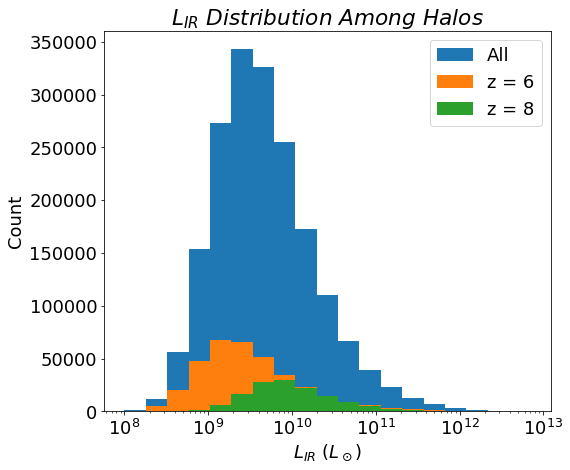

In [8]:
ir_binning = np.logspace(np.log10(10**8), np.log10(7*(10**12)), 20)

plt.hist(halo_IR, bins = ir_binning, label = 'All')
plt.hist(halo_IR[z6], bins = ir_binning, label = 'z = 6')
plt.hist(halo_IR[z8], bins = ir_binning, label = 'z = 8')
plt.xscale('log')

plt.title(r'$L_{IR}\ Distribution\ Among\ Halos$')
plt.xlabel(r'$L_{IR}\ (L_\odot)$')
plt.ylabel('Count')
plt.legend()

ir_bin_center = (ir_binning[:-1] + ir_binning[1:]) / 2

In [9]:
def get_mean(ir, cii, z, binning):
    
    data_z = (cii/ir)[z]
    bins_z = ir[z]
    
    mean_z = stats.binned_statistic(bins_z, data_z, 'mean', bins = binning)
        
    perc68down_z = stats.binned_statistic(bins_z, data_z, statistic = lambda y: np.percentile(y, 0.15+2.35+13.5), bins = binning)
    perc68up_z = stats.binned_statistic(bins_z, data_z, statistic = lambda y: np.percentile(y, 0.15+2.35+13.5+68), bins = binning)
    
    perc95down_z = stats.binned_statistic(bins_z, data_z, statistic = lambda y: np.percentile(y, 0.15+2.35), bins = binning)
    perc95up_z = stats.binned_statistic(bins_z, data_z, statistic = lambda y: np.percentile(y, 0.15+2.35+13.5+68+13.5), bins = binning)
    
    n_z = stats.binned_statistic(bins_z, data_z, 'sum', bins = binning)
    
    non_nan = np.logical_not(np.isnan(mean_z[0]))

    return mean_z[0][non_nan], perc68down_z[0][non_nan], perc68up_z[0][non_nan], perc95down_z[0][non_nan], perc95up_z[0][non_nan], n_z[0][non_nan], non_nan

In [38]:
def get_mean(ir, cii, z, binning):
    
    data_z = (cii/ir)[z]
    bins_z = ir[z]
    
    mean_z = stats.binned_statistic(bins_z, data_z, 'mean', bins = binning)
        
    perc68down_z = stats.binned_statistic(bins_z, data_z, statistic = lambda y: np.percentile(y, 0.15+2.35+13.5), bins = binning)
    perc68up_z = stats.binned_statistic(bins_z, data_z, statistic = lambda y: np.percentile(y, 0.15+2.35+13.5+68), bins = binning)
    
    perc95down_z = stats.binned_statistic(bins_z, data_z, statistic = lambda y: np.percentile(y, 0.15+2.35), bins = binning)
    perc95up_z = stats.binned_statistic(bins_z, data_z, statistic = lambda y: np.percentile(y, 0.15+2.35+13.5+68+13.5), bins = binning)
    
    n_z = stats.binned_statistic(bins_z, data_z, 'sum', bins = binning)
    
    non_nan = np.logical_not(np.isnan(mean_z[0]))
    
    new_bins = []

    for i in range(len(mean_z[0])):
        if ~np.isnan(mean_z[0][i]):
            new_bins.append((binning[i], binning[i+1]))

    return mean_z[0][non_nan], perc68down_z[0][non_nan], perc68up_z[0][non_nan], perc95down_z[0][non_nan], perc95up_z[0][non_nan], n_z[0][non_nan], new_bins, non_nan

In [39]:
mean_z6, perc68down_z6, perc68up_z6, perc95down_z6, perc95up_z6, n_z6, bins_z6, nn_z6 = get_mean(halo_IR, halos_cii, z6, ir_binning)

mean_z8, perc68down_z8, perc68up_z8, perc95down_z8, perc95up_z8, n_z8, bins_z8, nn_z8 = get_mean(halo_IR, halos_cii, z8, ir_binning)

In [40]:
alpha_z6 = n_z6/np.max(n_z6)
alpha_z8 = n_z8/np.max(n_z8)

first version:

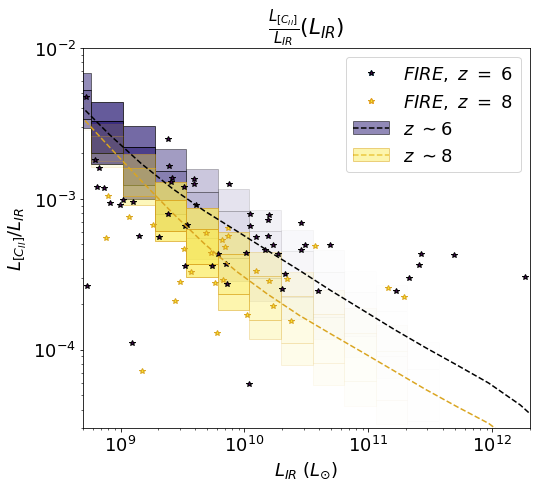

In [51]:
f, a = plt.subplots()

plt.title(r'$\frac{L_{[C_{II}]}}{L_{IR}}(L_{IR})$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ 8$', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])


for i in range(len(ir_bin_center[nn_z6])):
    
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc68down_z6[i], perc68up_z6[i], edgecolor='k', facecolor = '#241571', alpha = 0.9*alpha_z6[i])
    
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc95down_z6[i], perc68down_z6[i], edgecolor='k', facecolor = '#241571', alpha = 0.7*alpha_z6[i])
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc68up_z6[i], perc95up_z6[i], edgecolor='k', facecolor = '#241571', alpha = 0.7*alpha_z6[i])
    

for i in range(len(ir_bin_center[nn_z8])):
    
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc68down_z8[i], perc68up_z8[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.9*alpha_z8[i])
    
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc95down_z8[i], perc68down_z8[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.7*alpha_z8[i])
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc68up_z8[i], perc95up_z8[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.7*alpha_z8[i])
    
    
p01 = a.plot(ir_bin_center[nn_z6], mean_z6, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='k', facecolor='#241571')

p03 = a.plot(ir_bin_center[nn_z8], mean_z8, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='#DAA520', facecolor='#FBEC5D')

a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [(r'$FIRE,\ z\ =\ 6$'), (r'$FIRE,\ z\ =\ 8$'), (r'$z\ \sim 6$'), (r'$z\ \sim 8$'), ], bbox_to_anchor = (1,1))


second version:

In [61]:
# hex code: #241571
fc6_r = 0.1411764705882353
fc6_g = 0.08235294117647059
fc6_b = 0.44313725490196076

# hex code: #000000
ec6_r = 0
ec6_g = 0
ec6_b = 0

# hex code: #FBEC5D
fc8_r = 0.984313725490196
fc8_g = 0.9254901960784314
fc8_b = 0.36470588235294116

# hex code: #DAA520
ec8_r = 0.8549019607843137
ec8_g = 0.6470588235294118
ec8_b = 0.12549019607843137

ec_op1 = 1
ec_op2 = 0.7

fc_op1 = 0
fc_op2 = 0

bin_lw = 2

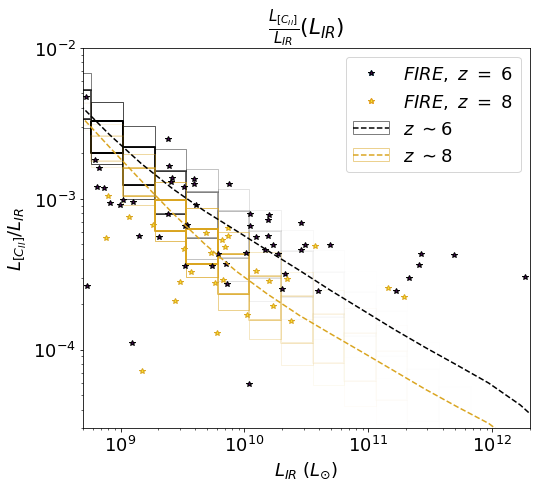

In [82]:
f, a = plt.subplots()

plt.title(r'$\frac{L_{[C_{II}]}}{L_{IR}}(L_{IR})$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ 8$', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])


for i in range(len(ir_bin_center[nn_z6])):
    
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc68down_z6[i], perc68up_z6[i], edgecolor = (ec6_r, ec6_g, ec6_b, ec_op1*alpha_z6[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op1*alpha_z6[i]), linewidth = bin_lw)
    
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc95down_z6[i], perc68down_z6[i], edgecolor = (ec6_r, ec6_g, ec6_b, ec_op2*alpha_z6[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op2*alpha_z6[i]))
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc68up_z6[i], perc95up_z6[i], edgecolor= (ec6_r, ec6_g, ec6_b, ec_op2*alpha_z6[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op2*alpha_z6[i]))
    

for i in range(len(ir_bin_center[nn_z8])):
    
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc68down_z8[i], perc68up_z8[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op1*alpha_z8[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op1*alpha_z8[i]), linewidth = bin_lw)
    
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc95down_z8[i], perc68down_z8[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op2*alpha_z8[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op2*alpha_z8[i]))
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc68up_z8[i], perc95up_z8[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op2*alpha_z8[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op2*alpha_z8[i]))
    
    
p01 = a.plot(ir_bin_center[nn_z6], mean_z6, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, edgecolor= (ec6_r, ec6_g, ec6_b, 0.5*ec_op1), facecolor = (fc6_r, fc6_g, fc6_b, 0.5*fc_op1))

p03 = a.plot(ir_bin_center[nn_z8], mean_z8, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, edgecolor = (ec8_r, ec8_g, ec8_b, 0.5*ec_op1), facecolor = (fc8_r, fc8_g, fc8_b, 0.5*fc_op1))

a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [(r'$FIRE,\ z\ =\ 6$'), (r'$FIRE,\ z\ =\ 8$'), (r'$z\ \sim 6$'), (r'$z\ \sim 8$'), ], bbox_to_anchor = (1,1))


In [91]:
# bin face color at z = 6
# hex code: #241571
fc6_r = 0.1411764705882353
fc6_g = 0.08235294117647059
fc6_b = 0.44313725490196076

# bin edge color ar z = 8
# hex code: #000000
ec6_r = 0
ec6_g = 0
ec6_b = 0

# bin face color at z = 6
# hex code: #FBEC5D
fc8_r = 0.984313725490196
fc8_g = 0.9254901960784314
fc8_b = 0.36470588235294116

# bin edge color at z = 8
# hex code: #DAA520
ec8_r = 0.8549019607843137
ec8_g = 0.6470588235294118
ec8_b = 0.12549019607843137

# bin edge opactiy
ec_op1 = 0.9
ec_op2 = 0.7

# bin face opacity
fc_op1 = 0.9
fc_op2 = 0.7

# bin edge linewidth
bin_lw = 2.5

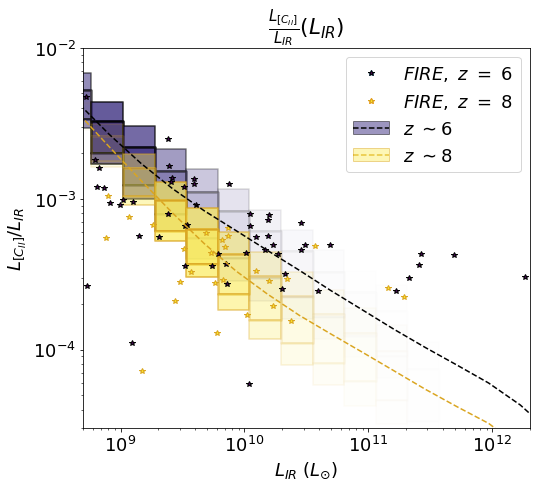

In [92]:
f, a = plt.subplots()

plt.title(r'$\frac{L_{[C_{II}]}}{L_{IR}}(L_{IR})$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ 8$', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])


for i in range(len(ir_bin_center[nn_z6])):
    
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc68down_z6[i], perc68up_z6[i], edgecolor = (ec6_r, ec6_g, ec6_b, ec_op1*alpha_z6[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op1*alpha_z6[i]), linewidth = bin_lw)
    
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc95down_z6[i], perc68down_z6[i], edgecolor = (ec6_r, ec6_g, ec6_b, ec_op2*alpha_z6[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op2*alpha_z6[i]), linewidth = .7*bin_lw)
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc68up_z6[i], perc95up_z6[i], edgecolor= (ec6_r, ec6_g, ec6_b, ec_op2*alpha_z6[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op2*alpha_z6[i]), linewidth = .7*bin_lw)
    

for i in range(len(ir_bin_center[nn_z8])):
    
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc68down_z8[i], perc68up_z8[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op1*alpha_z8[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op1*alpha_z8[i]), linewidth = bin_lw)
    
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc95down_z8[i], perc68down_z8[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op2*alpha_z8[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op2*alpha_z8[i]), linewidth = .7*bin_lw)
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc68up_z8[i], perc95up_z8[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op2*alpha_z8[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op2*alpha_z8[i]), linewidth = .7*bin_lw)
    
    
p01 = a.plot(ir_bin_center[nn_z6], mean_z6, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, edgecolor= (ec6_r, ec6_g, ec6_b, 0.5*ec_op1), facecolor = (fc6_r, fc6_g, fc6_b, 0.5*fc_op1))

p03 = a.plot(ir_bin_center[nn_z8], mean_z8, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, edgecolor = (ec8_r, ec8_g, ec8_b, 0.5*ec_op1), facecolor = (fc8_r, fc8_g, fc8_b, 0.5*fc_op1))

a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [(r'$FIRE,\ z\ =\ 6$'), (r'$FIRE,\ z\ =\ 8$'), (r'$z\ \sim 6$'), (r'$z\ \sim 8$'), ], bbox_to_anchor = (1,1))

plt.savefig('paper_figs/fig6_lcii_lir/plot_tryouts/')


Second Model

In [93]:
m_cii_v2 = lim('Lichen_v4', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [94]:
m_cii_v2.update(model_par = {'zdex': 0.4,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'},
            nuObs = 246*u.GHz,
            Delta_nu = 64*u.GHz,
            dnu = 2.8*u.GHz,
            Omega_field = 4*u.deg**2,
            catalogue_file  = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

In [95]:
halos_cii_v2 = m_cii_v2.L_halos.value

Loading .npz catalogues...


In [96]:
mean_z6v2, perc68down_z6v2, perc68up_z6v2, perc95down_z6v2, perc95up_z6v2, n_z6v2, bins_z6v2, nn_z6v2 = get_mean(halo_IR, halos_cii_v2, z6, ir_binning)

mean_z8v2, perc68down_z8v2, perc68up_z8v2, perc95down_z8v2, perc95up_z8v2, n_z8v2, bins_z8v2, nn_z8v2 = get_mean(halo_IR, halos_cii_v2, z8, ir_binning)

In [97]:
alpha_z6v2 = n_z6v2/np.max(n_z6v2)
alpha_z8v2 = n_z8v2/np.max(n_z8v2)

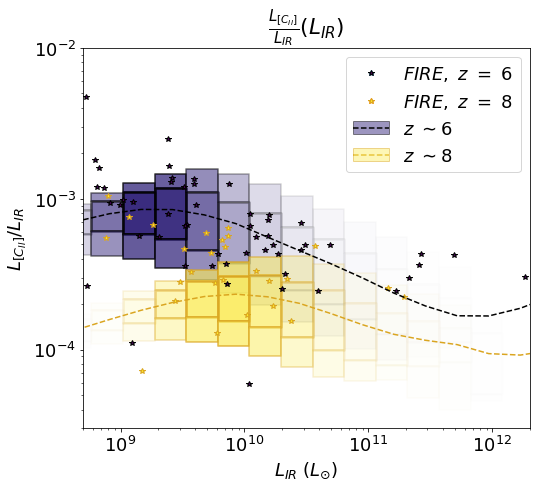

In [98]:
f, a = plt.subplots()

plt.title(r'$\frac{L_{[C_{II}]}}{L_{IR}}(L_{IR})$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ 8$', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])


for i in range(len(ir_bin_center[nn_z6v2])):
    
    a.fill_between((bins_z6v2[i][0], bins_z6v2[i][1]), perc68down_z6v2[i], perc68up_z6v2[i], edgecolor = (ec6_r, ec6_g, ec6_b, ec_op1*alpha_z6v2[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op1*alpha_z6v2[i]), linewidth = bin_lw)
    
    a.fill_between((bins_z6v2[i][0], bins_z6v2[i][1]), perc95down_z6v2[i], perc68down_z6v2[i], edgecolor = (ec6_r, ec6_g, ec6_b, ec_op2*alpha_z6v2[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op2*alpha_z6v2[i]), linewidth = .7*bin_lw)
    a.fill_between((bins_z6v2[i][0], bins_z6v2[i][1]), perc68up_z6v2[i], perc95up_z6v2[i], edgecolor= (ec6_r, ec6_g, ec6_b, ec_op2*alpha_z6v2[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op2*alpha_z6v2[i]), linewidth = .7*bin_lw)
    

for i in range(len(ir_bin_center[nn_z8v2])):
    
    a.fill_between((bins_z8v2[i][0], bins_z8v2[i][1]), perc68down_z8v2[i], perc68up_z8v2[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op1*alpha_z8v2[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op1*alpha_z8v2[i]), linewidth = bin_lw)
    
    a.fill_between((bins_z8v2[i][0], bins_z8[i][1]), perc95down_z8v2[i], perc68down_z8v2[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op2*alpha_z8v2[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op2*alpha_z8v2[i]), linewidth = .7*bin_lw)
    a.fill_between((bins_z8v2[i][0], bins_z8v2[i][1]), perc68up_z8v2[i], perc95up_z8v2[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op2*alpha_z8v2[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op2*alpha_z8v2[i]), linewidth = .7*bin_lw)
    
    
p01 = a.plot(ir_bin_center[nn_z6v2], mean_z6v2, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, edgecolor= (ec6_r, ec6_g, ec6_b, 0.5*ec_op1), facecolor = (fc6_r, fc6_g, fc6_b, 0.5*fc_op1))

p03 = a.plot(ir_bin_center[nn_z8v2], mean_z8v2, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, edgecolor = (ec8_r, ec8_g, ec8_b, 0.5*ec_op1), facecolor = (fc8_r, fc8_g, fc8_b, 0.5*fc_op1))

a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [(r'$FIRE,\ z\ =\ 6$'), (r'$FIRE,\ z\ =\ 8$'), (r'$z\ \sim 6$'), (r'$z\ \sim 8$'), ], bbox_to_anchor = (1,1))


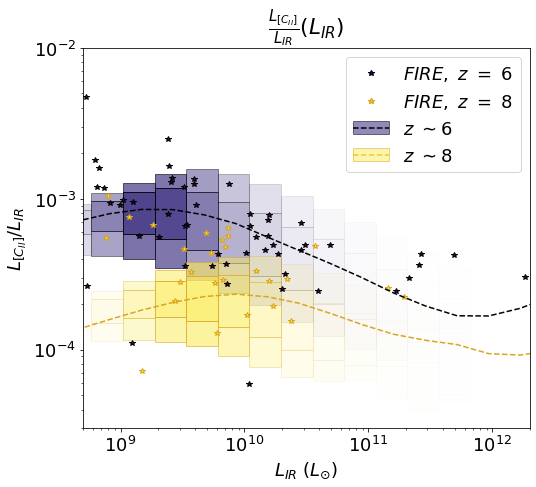

In [25]:
f, a = plt.subplots()

plt.title(r'$\frac{L_{[C_{II}]}}{L_{IR}}(L_{IR})$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ 8$', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L_{IR}\ (L_{\odot})$')
plt.ylabel(r'$L_{[C_{II}]}/L_{IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])

for i in range(len(ir_bin_center[nn_z6v2])):
    
    a.fill_between((ir_binning[i], ir_binning[i+1]), perc68down_z6v2[i], perc68up_z6v2[i], edgecolor='k', facecolor='#241571', alpha = 0.8*alpha_z6v2[i])
    
    a.fill_between((ir_binning[i], ir_binning[i+1]), perc95down_z6v2[i], perc68down_z6v2[i], edgecolor='k', facecolor='#241571', alpha = 0.6*alpha_z6v2[i])
    a.fill_between((ir_binning[i], ir_binning[i+1]), perc68up_z6v2[i], perc95up_z6v2[i], edgecolor='k', facecolor='#241571', alpha = 0.6*alpha_z6v2[i])
    

for i in range(len(ir_bin_center[nn_z8v2])):
    
    a.fill_between((ir_binning[i], ir_binning[i+1]), perc68down_z8v2[i], perc68up_z8v2[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.8*alpha_z8v2[i])
    
    a.fill_between((ir_binning[i], ir_binning[i+1]), perc95down_z8v2[i], perc68down_z8v2[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.6*alpha_z8v2[i])
    a.fill_between((ir_binning[i], ir_binning[i+1]), perc68up_z8v2[i], perc95up_z8v2[i], edgecolor='#DAA520', facecolor='#FBEC5D', alpha = 0.6*alpha_z8v2[i])

p01 = a.plot(ir_bin_center[nn_z6v2], mean_z6v2, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='k', facecolor='#241571')

p03 = a.plot(ir_bin_center[nn_z8v2], mean_z8v2, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, alpha=0.5, edgecolor='#DAA520', facecolor='#FBEC5D')

a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [(r'$FIRE,\ z\ =\ 6$'), (r'$FIRE,\ z\ =\ 8$'), (r'$z\ \sim 6$'), (r'$z\ \sim 8$'), ], bbox_to_anchor = (1,1))


Plot tryouts:

In [155]:
# bin face color at z = 6
# hex code: #241571
fc6_r = 0.1411764705882353
fc6_g = 0.08235294117647059
fc6_b = 0.44313725490196076

# bin edge color ar z = 8
# hex code: #000000
ec6_r = 0
ec6_g = 0
ec6_b = 0

# bin face color at z = 6
# hex code: #FBEC5D
fc8_r = 0.984313725490196
fc8_g = 0.9254901960784314
fc8_b = 0.36470588235294116

# bin edge color at z = 8
# hex code: #DAA520
ec8_r = 0.8549019607843137
ec8_g = 0.6470588235294118
ec8_b = 0.12549019607843137

# bin edge opactiy
ec_op1 = 1
ec_op2 = 0.8

# bin face opacity
fc_op1 = 0
fc_op2 = 0

# bin edge linewidth
bin_lw = 2.5

In [139]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{tgheros}\\usepackage{sansmath}\\sansmath'

In [ ]:
f, a = plt.subplots()

plt.title('$L_{\\rm [C\\, II]}/L_{\\rm IR}(L_{\\rm IR})$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$L_{\\rm IR}\ (L_{\\odot})$')
plt.ylabel('$L_{\\rm [C\\, II]}/L_{\\rm IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])


for i in range(len(ir_bin_center[nn_z6])):
    
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc68down_z6[i], perc68up_z6[i], edgecolor = (ec6_r, ec6_g, ec6_b, ec_op1*alpha_z6[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op1*alpha_z6[i]), linewidth = bin_lw)
    
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc95down_z6[i], perc68down_z6[i], edgecolor = (ec6_r, ec6_g, ec6_b, ec_op2*alpha_z6[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op2*alpha_z6[i]), linewidth = .7*bin_lw)
    a.fill_between((bins_z6[i][0], bins_z6[i][1]), perc68up_z6[i], perc95up_z6[i], edgecolor= (ec6_r, ec6_g, ec6_b, ec_op2*alpha_z6[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op2*alpha_z6[i]), linewidth = .7*bin_lw)
    

for i in range(len(ir_bin_center[nn_z8])):
    
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc68down_z8[i], perc68up_z8[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op1*alpha_z8[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op1*alpha_z8[i]), linewidth = bin_lw)
    
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc95down_z8[i], perc68down_z8[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op2*alpha_z8[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op2*alpha_z8[i]), linewidth = .7*bin_lw)
    a.fill_between((bins_z8[i][0], bins_z8[i][1]), perc68up_z8[i], perc95up_z8[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op2*alpha_z8[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op2*alpha_z8[i]), linewidth = .7*bin_lw)
    
    
p01 = a.plot(ir_bin_center[nn_z6], mean_z6, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, edgecolor= (ec6_r, ec6_g, ec6_b, 0.5*ec_op1), facecolor = (fc6_r, fc6_g, fc6_b, 0.5*fc_op1))

p03 = a.plot(ir_bin_center[nn_z8], mean_z8, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, edgecolor = (ec8_r, ec8_g, ec8_b, 0.5*ec_op1), facecolor = (fc8_r, fc8_g, fc8_b, 0.5*fc_op1))

a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [('FIRE, z = 6'), ('FIRE, z = 8'), ('z $\\approx$ 6'), ('z $\\approx$ 8'), ], bbox_to_anchor = (1,1))

plt.savefig('paper_figs/fig6_lcii_lir/plot_tryouts/v1/7.pdf', bbox_inches = 'tight')

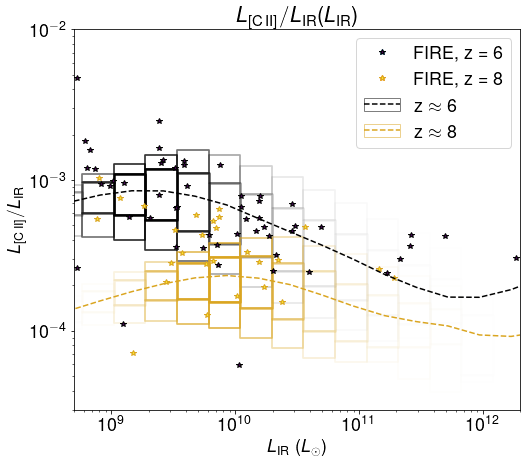

In [157]:
f, a = plt.subplots()

plt.title('$L_{\\rm [C\\, II]}/L_{\\rm IR}(L_{\\rm IR})$')

p6 = a.plot(fire_ir_z6, (fire_cii_z6/fire_ir_z6), c = '#440154FF', marker = '*', markeredgecolor='k', label = r'$FIRE,\ z\ =\ 6$', linestyle = "None")
p6l = a.plot(np.nan, np.nan, '*')

p8 = a.plot(fire_ir_z8, (fire_cii_z8/fire_ir_z8), c = '#FDE725FF', marker = '*', markeredgecolor='#DAA520', label = r'$FIRE,\ z\ =\ 8$', linestyle = "None")
p8l = a.plot(np.nan, np.nan, '*')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$L_{\\rm IR}\ (L_{\\odot})$')
plt.ylabel('$L_{\\rm [C\\, II]}/L_{\\rm IR}$')
plt.xlim([5*(10**8), 2*(10**12)])
plt.ylim([3*(10**(-5)), (10**(-2))])


for i in range(len(ir_bin_center[nn_z6v2])):
    
    a.fill_between((bins_z6v2[i][0], bins_z6v2[i][1]), perc68down_z6v2[i], perc68up_z6v2[i], edgecolor = (ec6_r, ec6_g, ec6_b, ec_op1*alpha_z6v2[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op1*alpha_z6v2[i]), linewidth = bin_lw)
    
    a.fill_between((bins_z6v2[i][0], bins_z6v2[i][1]), perc95down_z6v2[i], perc68down_z6v2[i], edgecolor = (ec6_r, ec6_g, ec6_b, ec_op2*alpha_z6v2[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op2*alpha_z6v2[i]), linewidth = .7*bin_lw)
    a.fill_between((bins_z6v2[i][0], bins_z6v2[i][1]), perc68up_z6v2[i], perc95up_z6v2[i], edgecolor= (ec6_r, ec6_g, ec6_b, ec_op2*alpha_z6v2[i]), facecolor = (fc6_r, fc6_g, fc6_b, fc_op2*alpha_z6v2[i]), linewidth = .7*bin_lw)
    

for i in range(len(ir_bin_center[nn_z8v2])):
    
    a.fill_between((bins_z8v2[i][0], bins_z8v2[i][1]), perc68down_z8v2[i], perc68up_z8v2[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op1*alpha_z8v2[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op1*alpha_z8v2[i]), linewidth = bin_lw)
    
    a.fill_between((bins_z8v2[i][0], bins_z8[i][1]), perc95down_z8v2[i], perc68down_z8v2[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op2*alpha_z8v2[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op2*alpha_z8v2[i]), linewidth = .7*bin_lw)
    a.fill_between((bins_z8v2[i][0], bins_z8v2[i][1]), perc68up_z8v2[i], perc95up_z8v2[i], edgecolor= (ec8_r, ec8_g, ec8_b, ec_op2*alpha_z8v2[i]), facecolor = (fc8_r, fc8_g, fc8_b, fc_op2*alpha_z8v2[i]), linewidth = .7*bin_lw)
    
    
p01 = a.plot(ir_bin_center[nn_z6v2], mean_z6v2, color = 'k', linestyle = '--')
p02 = a.fill(np.nan, np.nan, edgecolor= (ec6_r, ec6_g, ec6_b, 0.5*ec_op1), facecolor = (fc6_r, fc6_g, fc6_b, 0.5*fc_op1))

p03 = a.plot(ir_bin_center[nn_z8v2], mean_z8v2, color = '#DAA520', linestyle = '--')
p04 = a.fill(np.nan, np.nan, edgecolor = (ec8_r, ec8_g, ec8_b, 0.5*ec_op1), facecolor = (fc8_r, fc8_g, fc8_b, 0.5*fc_op1))

a.legend([(p6l[0], p6[0]), (p8l[0], p8[0]), (p02[0], p01[0]), (p03[0], p04[0]), ], [('FIRE, z = 6'), ('FIRE, z = 8'), ('z $\\approx$ 6'), ('z $\\approx$ 8'), ], bbox_to_anchor = (1,1))

plt.savefig('paper_figs/fig6_lcii_lir/plot_tryouts/v2/7.pdf', bbox_inches = 'tight')